# Self RAG

Self-RAG is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents and generations. 

[Paper](https://arxiv.org/abs/2310.11511)

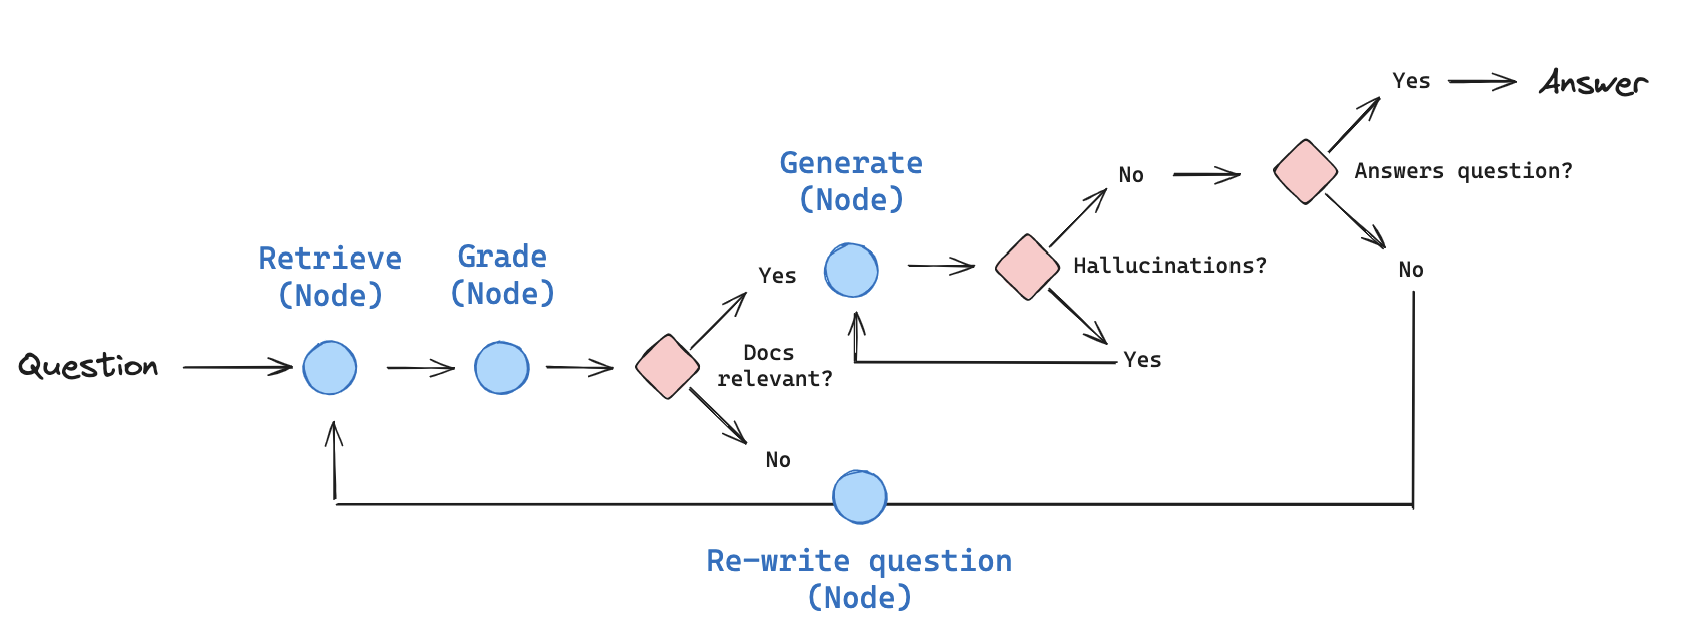

# Environment 

In [ ]:
%pip install -qU langchain-pinecone langchain-openai langchainhub langgraph

### Tracing

Use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom)

In [ ]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "<your-api-key>"

In [1]:
import os

os.environ["LANGCHAIN_PROJECT"] = "pinecone-devconnect"

## Retriever
 
Let's use Pinecone's sample movies database

In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

# use pinecone movies database

# Add to vectorDB
vectorstore = PineconeVectorStore(
    embedding=OpenAIEmbeddings(),
    index_name="sample-movies",
    text_key="summary",
)
retriever = vectorstore.as_retriever()

In [3]:
docs = retriever.invoke("James Cameron")
for doc in docs:
    print("# " + doc.metadata["title"])
    print(doc.page_content)
    print()

# Avatar
On the alien world of Pandora, paraplegic Marine Jake Sully uses an avatar to walk again and becomes torn between his mission and protecting the planet's indigenous Na'vi people. The film stars Sam Worthington, Zoe Saldana, and Sigourney Weaver.

# Top Gun: Maverick
Capt. Pete "Maverick" Mitchell, after decades of service as one of the Navy's top aviators, confronts his past while training a new squad for a dangerous mission. Tom Cruise reprises his iconic role, showcasing thrilling aerial stunts.

# Jurassic World Dominion
The film concludes the story of Jurassic World, with humanity now living alongside dinosaurs. It follows Owen Grady and Claire Dearing as they navigate this new world.

# Aquaman
Arthur Curry learns he is the heir to the underwater kingdom of Atlantis and must step forward to lead his people and be a hero to the world. Stars Jason Momoa, Amber Heard, and Willem Dafoe.



## Structured Output - Retrieval Grader

In [4]:
### Retrieval Grader

from langchain import hub
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# https://smith.langchain.com/hub/efriis/self-rag-retrieval-grader
grade_prompt = hub.pull("efriis/self-rag-retrieval-grader")

# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

retrieval_grader = grade_prompt | structured_llm_grader

In [5]:
# Test the retrieval grader
question = "movies starring jason momoa"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(doc_txt)
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

Arthur Curry learns he is the heir to the underwater kingdom of Atlantis and must step forward to lead his people and be a hero to the world. Stars Jason Momoa, Amber Heard, and Willem Dafoe.
binary_score='yes'


# Generation Step

Standard RAG

In [6]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Jason Momoa stars in the movies "Aquaman" and "Furious 7."


In [7]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# https://smith.langchain.com/hub/efriis/self-rag-hallucination-grader
hallucination_prompt = hub.pull("efriis/self-rag-hallucination-grader")

hallucination_grader = hallucination_prompt | structured_llm_grader
print(generation)
hallucination_grader.invoke({"documents": docs, "generation": generation})

Jason Momoa stars in the movies "Aquaman" and "Furious 7."


GradeHallucinations(binary_score='yes')

In [8]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = hub.pull("efriis/self-rag-answer-grader")

answer_grader = answer_prompt | structured_llm_grader
print(question)
print(generation)
answer_grader.invoke({"question": question, "generation": generation})

movies starring jason momoa
Jason Momoa stars in the movies "Aquaman" and "Furious 7."


GradeAnswer(binary_score='yes')

In [9]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
re_write_prompt = hub.pull("efriis/self-rag-question-rewriter")

question_rewriter = re_write_prompt | llm | StrOutputParser()
print(question)
question_rewriter.invoke({"question": question})

movies starring jason momoa


'Which movies feature Jason Momoa in a leading role?'

# Graph 

Capture the flow in as a graph.

## Graph state

In [10]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [11]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [12]:
### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

The just follows the flow we outlined in the figure above.

In [13]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [14]:
from pprint import pprint

# Run
inputs = {"question": "Movies that star Daniel Craig"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
'Daniel Craig stars as 007 in "Skyfall" (2012) and "Spectre" (2015).'


In [ ]:
inputs = {"question": "Which movies are about aliens?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])